I wanted to analyse if betting on football is profitable or not for noobs who have little or no knowledge of the sport. Others on Kaggle have analysed & found that home advantage is a significant factor in football, & more often than not the home team is the bookies' favourite to win the match. I'll investigate  a **few simple betting approaches** with applying different **financial strategies** - 

1.  Bet on the **safest outcome** for every match (i.e, the one with lowest  odds).  
2. Bet on the **underdog** (most unlikely outcome)  for every match (i.e, the  one with highest odds).
3. Bet on the **home team** for every match

Use following financial strategies:
1. **Flat** - fixed stake
2. **Expected Profit** - hope this approach has correct naming, main idea that I want to get fixed profit per each stake.

and in next series will use:
- **Fixed Percent Of Bank** - bet every time with fixed percent of bank, eg 1%
- **Progressive System** - just simple Martingale as well-known approach.

I'm using the odds from Bet365 mostly due more matches ...

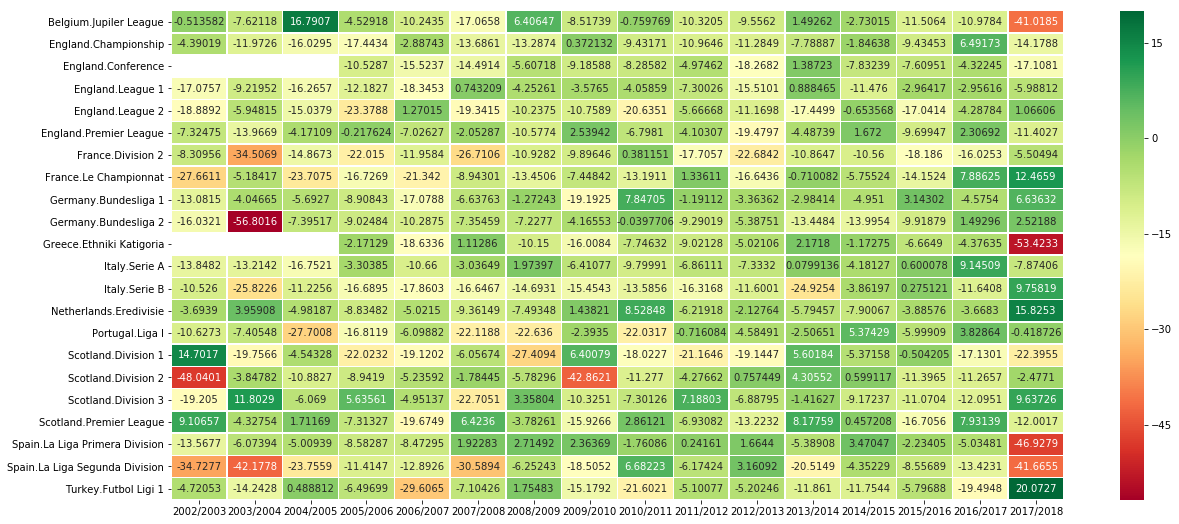

In [1]:
#include libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3

## Data Mungling

In [2]:
BOOKIE = {
    'BET365': ['B365H', 'B365D', 'B365A'],
    'PS': ['PSH', 'PSD', 'PSA'],
    'WH': ['WHH', 'WHD', 'WHA'],
    'BWIN': ['BWH', 'BWD', 'BWA'],
    'LB': ['LBH', 'LBD', 'LBA'] 
}


MATCH_INFO = [
    'DATE', 'SEASON', 'COUNTRY', 'LEAGUE', 'DIV', 'HOMETEAM', 'AWAYTEAM',
    'FTAG', 'FTHG', 'FTR'
]

#load the data. (P.S - copied this from Yoni Lev's Kernel)
def load_data():
    with sqlite3.connect('../input/database.sqlite') as con:
        all_data = pd.read_sql_query("SELECT * from Match", con)
        
    return all_data


def load_and_normalize_data(bookie='BET365'):
    match_info = load_data()
    match_info.columns = [col.upper() for col in match_info.columns]
    
    match_info = match_info[MATCH_INFO + BOOKIE[bookie]].rename(
        columns={
            'HOMETEAM': 'HOME_TEAM',
            'AWAYTEAM': 'AWAY_TEAM',
            'FTHG': 'HOME_TEAM_GOAL',
            'FTAG': 'AWAY_TEAM_GOAL', 
            'FTR': 'RESULT'
        }
    )
    
    match_info = match_info.sort_values(by='DATE', ascending=True)
    print('Dataset[Full] Shape = {}'.format(match_info.shape))
    match_info = match_info.dropna()
    
    match_info.loc[:, 'LEAGUE'] = match_info['COUNTRY'] + '.' + match_info['LEAGUE']
    match_info.loc[:, 'HOME_TEAM'] = match_info['DIV'] + '.' + match_info['HOME_TEAM']
    match_info.loc[:, 'AWAY_TEAM'] = match_info['DIV'] + '.' + match_info['AWAY_TEAM']

    print('Dataset[DropNA] Shape = {}'.format(match_info.shape))
    
    return match_info

In [3]:
# Total Matches Over Seasons
data = load_and_normalize_data(bookie='BET365')
season_gr = data[['LEAGUE', 'SEASON']].groupby(by=['LEAGUE', 'SEASON']).size().unstack(fill_value=0)
season_gr

Dataset[Full] Shape = (109695, 13)
Dataset[DropNA] Shape = (46988, 13)


SEASON,2002/2003,2003/2004,2004/2005,2005/2006,2006/2007,2007/2008,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016,2016/2017,2017/2018
LEAGUE,,,,,,,,,,,,,,,,
Belgium.Jupiler League,49,144,66,126,130,135,129,81,101,112,113,118,117,103,111,21
England.Championship,249,222,159,224,220,225,240,231,256,238,219,218,250,230,225,26
England.Conference,0,0,0,196,226,229,208,230,251,222,243,242,234,218,240,41
England.League 1,150,218,164,235,233,218,239,246,242,252,219,230,238,240,235,21
England.League 2,120,196,173,219,236,209,205,235,238,238,245,231,225,229,230,26
England.Premier League,134,160,142,168,158,156,174,179,175,173,171,181,164,175,172,19
France.Division 2,62,8,156,155,148,144,146,160,174,150,160,165,145,163,171,25
France.Le Championnat,74,89,170,161,156,172,157,155,171,153,172,160,158,163,173,21
Germany.Bundesliga 1,130,88,143,142,140,130,142,142,129,131,146,144,158,131,135,8


## Utilities To Apply Results and Strategies

In [4]:
def apply_result_on_favorite(x):
#     print(x.values)
    _result, _home, _draw, _away = x
    
    if (min(_home, _draw, _away) == _home) and (_result == 'H'):
        return 'H'
    elif (min(_home, _draw, _away) == _draw) and (_result == 'D'):
        return 'D'
    elif (min(_home, _draw, _away) == _away) and (_result == 'A'):
        return 'A'
    else:
        return 'OTHER'
        
        
def apply_result_on_dog(x):
#     print(x.values)
    _result, _home, _draw, _away = x
    
    if (max(_home, _draw, _away) == _home) and (_result == 'H'):
        return 'H'
    elif (max(_home, _draw, _away) == _draw) and (_result == 'D'):
        return 'D'
    elif (max(_home, _draw, _away) == _away) and (_result == 'A'):
        return 'A'
    else:
        return 'OTHER'

def apply_results(match_info):
    #compute the match result (i.e Home win/Draw/Away win) from the goals data for the match
    match_info['RESULT'] = 'H'
    match_info.loc[match_info.HOME_TEAM_GOAL == match_info.AWAY_TEAM_GOAL, "RESULT"] = 'D'
    match_info.loc[match_info.HOME_TEAM_GOAL < match_info.AWAY_TEAM_GOAL, "RESULT"] = 'A'

    match_info.loc[:, 'ODDS_ON_HOME'] = match_info['B365H']
    match_info.loc[:, 'ODDS_ON_FAVORITE'] = match_info[['B365H', 'B365D', 'B365A']].min(axis=1)
    match_info.loc[:, 'ODDS_ON_DOG'] = match_info[['B365H', 'B365D', 'B365A']].max(axis=1)

    #find the match outcome corresponding to the safest & riskiest odds
    match_info.loc[:, 'RESULT_ON_HOME'] = 'OTHER'
    match_info.loc[match_info.RESULT == 'H', 'RESULT_ON_HOME'] = 'H'

    match_info.loc[:, 'RESULT_ON_FAVORITE'] = match_info[['RESULT', 'B365H', 'B365D', 'B365A']].apply(
        apply_result_on_favorite,
        axis='columns'
    )

    match_info.loc[:, 'RESULT_ON_DOG'] = match_info[['RESULT', 'B365H', 'B365D', 'B365A']].apply(
        apply_result_on_dog,
        axis='columns'
    )
    return match_info


FLAT_STAKE = 10
BANK = 1000
DESIRE_PROFIT = 20

def apply_finance_strategy(match_info, strategy='FLAT'):
    if strategy == 'FLAT':
        match_info['STAKE_ON_HOME'] = FLAT_STAKE
        match_info['STAKE_ON_FAVORITE'] = FLAT_STAKE
        match_info['STAKE_ON_DOG'] = FLAT_STAKE
    else:
        match_info['STAKE_ON_HOME'] = float(DESIRE_PROFIT) / (match_info.ODDS_ON_HOME - 1)
        match_info['STAKE_ON_FAVORITE'] = float(DESIRE_PROFIT) / (match_info.ODDS_ON_FAVORITE - 1)    
        match_info['STAKE_ON_DOG'] = float(DESIRE_PROFIT) / (match_info.ODDS_ON_DOG - 1)
        
    match_info['PAYOUT_ON_HOME'] =  match_info.ODDS_ON_HOME * match_info.STAKE_ON_HOME
    match_info.loc[~(match_info.RESULT_ON_HOME == match_info.RESULT), 'PAYOUT_ON_HOME'] = 0

    match_info['PAYOUT_ON_FAVORITE'] = match_info.ODDS_ON_FAVORITE * match_info.STAKE_ON_FAVORITE
    match_info.loc[~(match_info.RESULT_ON_FAVORITE == match_info.RESULT), 'PAYOUT_ON_FAVORITE'] = 0
    
    match_info['PAYOUT_ON_DOG'] = match_info.ODDS_ON_DOG * match_info.STAKE_ON_DOG
    match_info.loc[~(match_info.RESULT_ON_DOG == match_info.RESULT), 'PAYOUT_ON_DOG'] = 0
    
    return match_info


def get_stats_from_matches(match_info, need_print=False):
    if match_info.shape[0] == 0:
        return None, None, None
    percent_on_home = match_info[~(match_info.PAYOUT_ON_HOME == 0)].shape[0] / float(match_info.shape[0])
    percent_on_favorite = match_info[~(match_info.PAYOUT_ON_FAVORITE == 0)].shape[0] / float(match_info.shape[0])
    percent_on_dog = match_info[~(match_info.PAYOUT_ON_DOG == 0)].shape[0] / float(match_info.shape[0])
    
    investment_on_home = match_info.STAKE_ON_HOME.sum()
    investment_on_favorite = match_info.STAKE_ON_FAVORITE.sum()
    investment_on_dog = match_info.STAKE_ON_DOG.sum()

    roi_on_home = sum(match_info.PAYOUT_ON_HOME)
    roi_on_favorite = sum(match_info.PAYOUT_ON_FAVORITE)
    roi_on_dog = sum(match_info.PAYOUT_ON_DOG)
    # calculate percantage reduction error what we stake vs earcn in %
    pre_on_home = (roi_on_home - investment_on_home)/investment_on_home * 100
    pre_on_favorite = (roi_on_favorite - investment_on_favorite)/investment_on_favorite * 100
    pre_on_dog = (roi_on_dog - investment_on_dog)/investment_on_dog * 100
    if need_print:
        print ("Correct bets for home={} | favorite={} | dog={}".format(percent_on_home, percent_on_favorite, percent_on_dog))
        print ("Net investment:", net_investment)
        print ("ROI for home={} | favorite={} | dog={}".format(roi_on_home, roi_on_favorite, roi_on_dog))
        print ("PRE for home={} | favorite={} | dog={}:".format(pre_on_home, pre_on_favorite, pre_on_dog))
    return pre_on_home, pre_on_favorite, pre_on_dog


def generate_stats_over_all_seasons(match_info):
    profitablity = {}
    stats_on_home = {}
    stats_on_favorite = {}
    stats_on_dog = {}

    for league in match_info['LEAGUE'].unique():
        for season in match_info['SEASON'].unique():
    #         print('Processing -> {} - {}'.format(league, season))
            match_df = match_info[
                (match_info['LEAGUE'] == league) & 
                (match_info['SEASON'] == season)
            ]
            on_home, on_favorite, on_dog = get_stats_from_matches(match_df)
            profitablity.setdefault(league, {}).setdefault(
                season, 
                {
                    'BET_ON_HOME': on_home,
                    'BET_ON_FAVORITE': on_favorite,
                    'BET_ON_DOG': on_dog
                }
            )
            stats_on_home.setdefault(league, {}).setdefault(season, on_home)
            stats_on_favorite.setdefault(league, {}).setdefault(season, on_favorite)
            stats_on_dog.setdefault(league, {}).setdefault(season, on_dog)
    
    return profitablity, stats_on_home, stats_on_favorite, stats_on_dog

## Start Rock&Roll

In [5]:
match_results = apply_results(data)
match_results.loc[:, [
    'RESULT', 'RESULT_ON_HOME', 'RESULT_ON_FAVORITE', 'RESULT_ON_DOG', 
    'ODDS_ON_HOME', 'ODDS_ON_FAVORITE', 'ODDS_ON_DOG',
    'B365H', 'B365D', 'B365A']].head(5)

,RESULT,RESULT_ON_HOME,RESULT_ON_FAVORITE,RESULT_ON_DOG,ODDS_ON_HOME,ODDS_ON_FAVORITE,ODDS_ON_DOG,B365H,B365D,B365A
108627,A,OTHER,OTHER,A,1.909,1.909,3.50,1.909,3.25,3.50
108629,D,OTHER,OTHER,D,2.750,2.250,3.25,2.750,3.25,2.25
108257,A,OTHER,A,OTHER,2.500,2.500,3.20,2.500,3.20,2.50
108256,H,H,H,OTHER,1.500,1.500,6.00,1.500,3.50,6.00
95290,A,OTHER,OTHER,OTHER,2.200,2.200,3.40,2.200,3.40,2.62


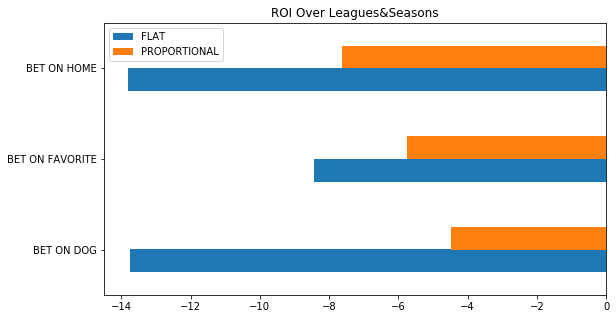

In [6]:
# Calculate ROI over for all matches
strategies_stats = {}
for strg in ['FLAT', 'PROPORTIONAL']:
    match_info = apply_finance_strategy(match_results, strategy=strg)
    on_home, on_favorite, on_dog = get_stats_from_matches(match_info)
    strategies_stats.setdefault(
        strg, {
            'BET ON HOME': on_home, 
            'BET ON FAVORITE': on_favorite, 
            'BET ON DOG': on_dog
        }
    )
pd.DataFrame(strategies_stats).plot(kind='barh', figsize=(9,5), title='ROI Over Leagues&Seasons')

In [7]:
# 
detail_strategies_stats = {}
for strg in ['FLAT', 'PROPORTIONAL']:
    match_info = apply_finance_strategy(match_results, strategy=strg)
    _, stats_on_home, stats_on_favorite, stats_on_dog = generate_stats_over_all_seasons(match_info)
    detail_strategies_stats.setdefault(
        strg, {
            'BET ON HOME': stats_on_home, 
            'BET ON FAVORITE': stats_on_favorite, 
            'BET ON DOG': stats_on_dog
        }
    )

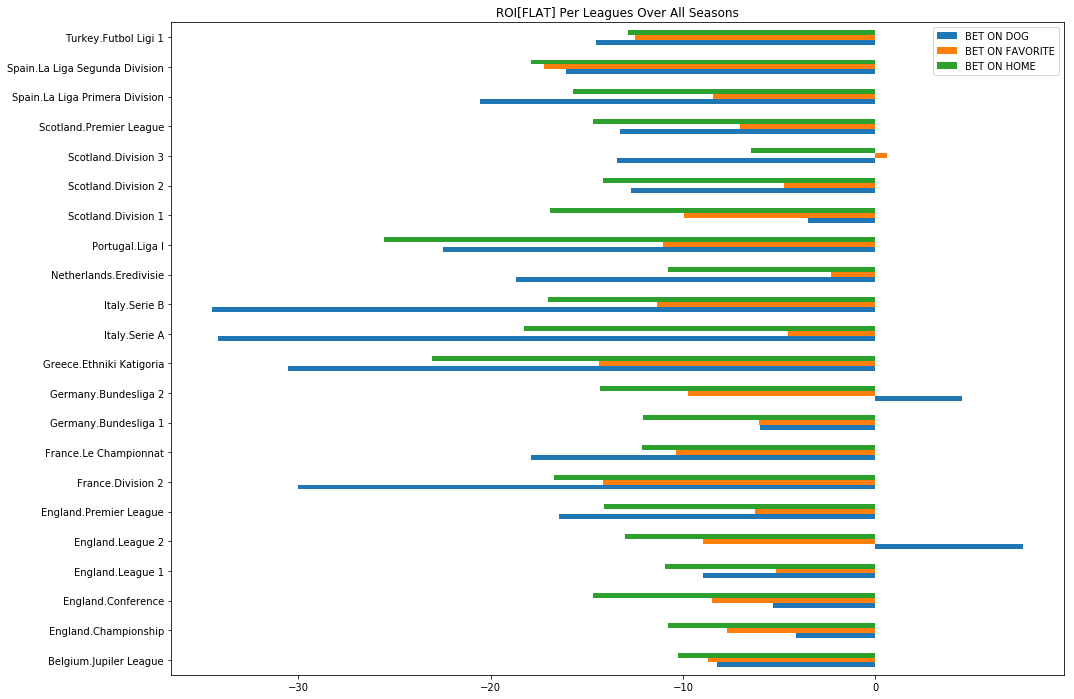

In [8]:
tmp = {}
for strg in ['BET ON HOME', 'BET ON FAVORITE', 'BET ON DOG']:
    tmp.setdefault(strg, pd.DataFrame(detail_strategies_stats['FLAT'][strg]).mean())
    
pd.DataFrame(tmp).plot(kind='barh', figsize=(16,12), title='ROI[FLAT] Per Leagues Over All Seasons')

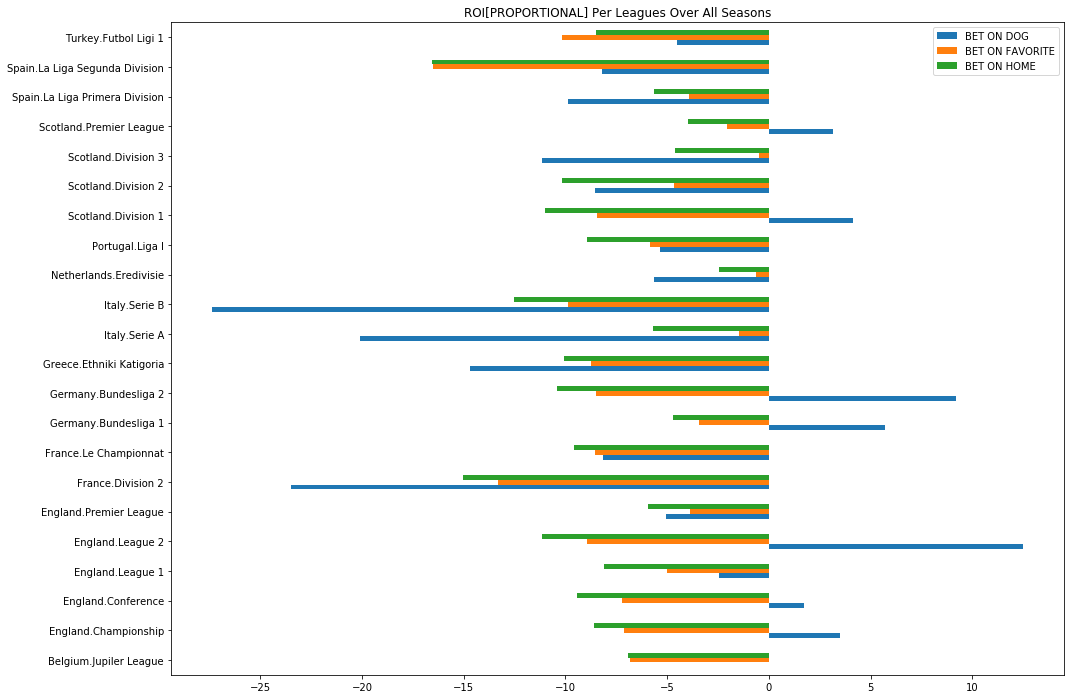

In [9]:
tmp = {}
for strg in ['BET ON HOME', 'BET ON FAVORITE', 'BET ON DOG']:
    tmp.setdefault(strg, pd.DataFrame(detail_strategies_stats['PROPORTIONAL'][strg]).mean())
    
pd.DataFrame(tmp).plot(kind='barh', figsize=(16,12), title='ROI[PROPORTIONAL] Per Leagues Over All Seasons')

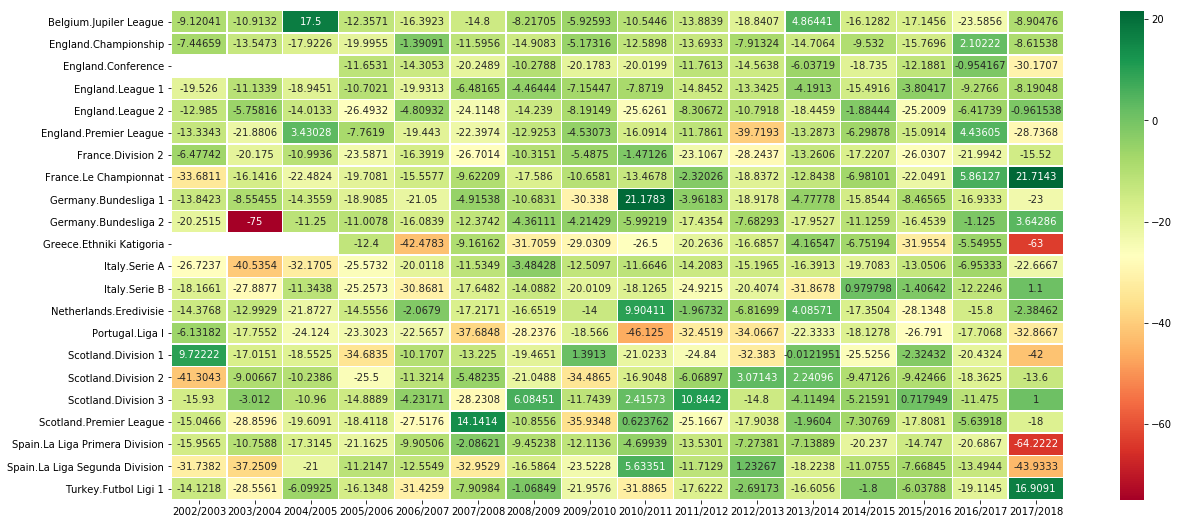

In [10]:
fig, ax = plt.subplots(figsize=(20, 9))   
sns.heatmap(
    pd.DataFrame(detail_strategies_stats['FLAT']['BET ON HOME']).T, 
    annot=True, 
    fmt="g", 
    cmap="RdYlGn",
    linewidths=.5,
    ax=ax
)


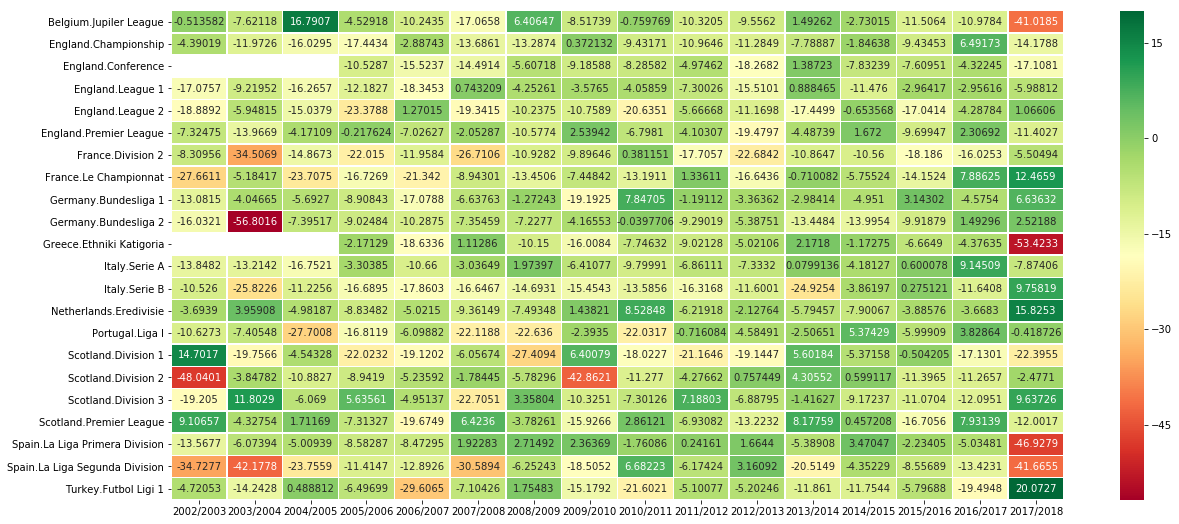

In [11]:
fig, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(
    pd.DataFrame(detail_strategies_stats['PROPORTIONAL']['BET ON HOME']).T, 
    annot=True, 
    fmt="g", 
    cmap="RdYlGn",
    linewidths=.5,
    ax=ax
)

## Summary

As expected and report shows: 
- financial managment does matter!
- naive strategies is supposed to lose in long game due bookies margin.


Also visualization even those naive steps really help to see some patterns/outliers, and we will continue reveal more tricks in next posts.

In [12]:
# to be continued ...